# Model Deployment Step by Step

## Step 1: tar zip all files in folder ./deployment as model-gpu.tar.gz, and put it under main directory
#### If you need to deploy another model, please update model_best.pth in ./deployment, and also change "Sets of parameters" part in ./deployment/code/inference.py. Please retain the file structures in ./deployment, and then tar zip them.

In [ ]:
!cd ../deployment
!tar -czvf ../model-gpu.tar.gz ./

## Step 2: Upload the model-gpu.tar.gz to an S3 bucket

In [ ]:
!aws s3 cp ../model-gpu.tar.gz s3://sherry-signature-detection  # Change to your bucket name

## Step 3: Deploy a realtime endpoint & Setup auto-scaling

In [19]:
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role
import boto3
import matplotlib.pyplot as plt
import cv2
import numpy as np
import io
from PIL import Image
import os
import json
%matplotlib inline

role = get_execution_role()
print(role)

arn:aws:iam::240487350066:role/service-role/AmazonSageMaker-ExecutionRole-20201028T114926


### Deploy a realtime endpoint 
#### First initalize a PytorchModel class, then call its deploy function

In [20]:
pytorch_model = PyTorchModel(
    model_data='s3://sherry-signature-detection/model-gpu.tar.gz', # Change to your bucket name
    role=role, 
    entry_point='inference.py', 
    framework_version='1.5.0', 
    py_version='py3'
)

In [21]:
REALTIME_ENDPOINT_NAME = 'signature-detection-gpu' 

predictor = pytorch_model.deploy(
    instance_type='ml.g4dn.xlarge',
#     instance_type='ml.m4.xlarge',
    initial_instance_count=1, 
    endpoint_name = REALTIME_ENDPOINT_NAME,
#     accelerator_type='ml.eia2.medium'
)

-------------------!

### Setup auto-scaling
#### First register a scalable target, then define a scaling policy

In [22]:
client = boto3.client('application-autoscaling')

response = client.register_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId=f"endpoint/{REALTIME_ENDPOINT_NAME}/variant/AllTraffic",
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',  # scale number of instances
    MinCapacity=1,  # min number of endpoint instance
    MaxCapacity=10, # max number of endpoint instance
    RoleARN=role,
)

In [23]:
# Change scaling policies if necessary
response = client.put_scaling_policy(
    PolicyName='SageMakerEndpointInvocationScalingPolicy',
    ServiceNamespace='sagemaker',
    ResourceId=f"endpoint/{REALTIME_ENDPOINT_NAME}/variant/AllTraffic",
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    PolicyType='TargetTrackingScaling',
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 70,
        'PredefinedMetricSpecification': {
            'PredefinedMetricType': 'SageMakerVariantInvocationsPerInstance',  # scale based upon this metric
        },
        'ScaleOutCooldown': 10,
        'ScaleInCooldown': 300,
        'DisableScaleIn': False
    }
)

## Step 4: Test the endpoint

### Call the endpoint

In [24]:
# WORKING_DIR = os.getcwd()
WORKING_DIR = '/home/ec2-user/SageMaker/ding_demo/'  # Change to your working directory
with open(os.path.join(WORKING_DIR, 'data/input/pic3.jpg'), 'rb') as f:  # Change to your testing image
    payload = f.read()
      
client = boto3.client("runtime.sagemaker")
response = client.invoke_endpoint(EndpointName=REALTIME_ENDPOINT_NAME, 
                                  ContentType="application/x-image", 
                                  Body=payload)

response 
# json.loads(response["Body"].read().decode("utf-8"))

{'ResponseMetadata': {'RequestId': '369a61aa-c37e-48b7-90b4-d23c40bfb0eb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '369a61aa-c37e-48b7-90b4-d23c40bfb0eb',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Wed, 6 Jan 2021 18:19:20 GMT',
   'content-type': 'application/json',
   'content-length': '376'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7f8c9caf9eb8>}

In [25]:
# Get response body content and convert it to a dictionary
response_dict = eval(response["Body"].read().decode("utf-8"))
response_dict

{'signature0': {'score': 0.9995638728141785,
  'roi': [368.6142883300781,
   815.865234375,
   532.2171020507812,
   868.3385009765625]},
 'signature1': {'score': 0.9995121955871582,
  'roi': [381.7952575683594,
   487.78424072265625,
   537.423583984375,
   539.2177124023438]},
 'signature2': {'score': 0.9396294951438904,
  'roi': [893.72509765625, 484.1945495605469, 1228.3828125, 553.2119140625]}}

### Plot signature detection result

In [26]:
INPUT_MAX_SIZE_TEST = 1600  # This is the same as INPUT_MAX_SIZE_TEST in inference.py

def _resize_img(img, target_height = INPUT_MAX_SIZE_TEST, target_width = INPUT_MAX_SIZE_TEST):
    """
    _resize_img resizes the image specified by the parameter img to the specified target width and height
    by maintaining the aspect ratio and adding a gray padding (127, 127, 127).

    :param target_height: target height.
    :param target_width: target width.
    
    :return: border_image: resized image
    :return: params: transformation parameters which were applied to img
    """ 
    
    h, w, _ = img.shape
    size_percent = min(target_height/h, target_width/w)
    new_h = int(h * size_percent)
    new_w = int(w * size_percent)
    new_img = cv2.resize(img, dsize = (new_w, new_h), interpolation = cv2.INTER_NEAREST)
    
    color = [127, 127, 127]
    border_img = np.full((target_height, target_width, 3), color, dtype = np.uint8)
    h, w, _ = new_img.shape
    
    h_margin = (target_height - h) // 2
    w_margin = (target_width - w) // 2
    
    params = [size_percent, h_margin, w_margin]
    border_img[h_margin:h_margin + h, w_margin:w_margin + w] = new_img
    
    return border_img, params

def show_prediction(payload, response_dict):
    """
    show_prediction return raw output preditions from RetinaNet signature detection model.

    :param payload: raw image
    :param response_dict: dictionary structure of response body returned from model 
    
    :return: image with bbox on it
    """ 
    im_rgb = np.array(Image.open(io.BytesIO(payload)).convert("RGB"))
    im_rgb, _ = _resize_img(im_rgb)
    
    for k in range(len(response_dict)):
        signature = response_dict[f'signature{k}']
        bbox = signature['roi']
        start_point = (int(bbox[0]), int(bbox[1]))
        end_point = (int(bbox[2]), int(bbox[3]))
        im_rgb = cv2.rectangle(im_rgb, start_point, end_point, (255,0,0), 3) 
    
    return im_rgb

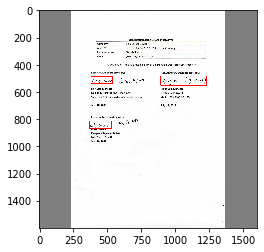

In [27]:
im_rgb = show_prediction(payload, response_dict)
plt.imshow(im_rgb)
plt.show()